In [1]:
import gc
import os
import sys
import math
import random
import warnings
import pickle
from pathlib import Path
from joblib import Parallel, delayed
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)

from tqdm import tqdm
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from pandarallel import pandarallel
# pandarallel.initialize()
warnings.simplefilter("ignore")
import ctypes as ct
from datetime import timedelta

from sklearn.metrics import mean_absolute_error


import lightgbm as lgbm


/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
sys.path.append('../../')
import src.utils as utils

In [3]:
EXP_NUM = 9

In [4]:
DATA_DIR = Path("/home/knikaido/work/MLB-Player-Digital-Engagement-Forecasting/data/")
MAIN_DATA_DIR = DATA_DIR / 'mlb-player-digital-engagement-forecasting'
TRAIN_DIR = MAIN_DATA_DIR / 'train'
OUTPUT_DIR = Path('./output/')

In [5]:
players = pd.read_csv(MAIN_DATA_DIR / 'players.csv')

rosters = pd.read_csv(TRAIN_DIR / 'rosters_train.csv')
targets = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')
scores = pd.read_csv(TRAIN_DIR / 'playerBoxScores_train.csv')
scores = scores.groupby(['playerId', 'date']).sum().reset_index()

In [6]:
TAGET_COL = ['target1', 'target2', 'target3', 'target4']

In [7]:
targets_train = targets[targets['date'] < 20210401]

In [8]:
targets_describe = targets_train.groupby('playerId').describe()

In [9]:
columns = []
targets_describe_columns = np.array(targets_describe.columns)
for i in range(len(targets_describe_columns)):
    c_ = targets_describe_columns[i][0] + '_' + targets_describe_columns[i][1]
    columns.append(c_)

In [10]:
targets_describe.columns = columns
drop_columns = [s for s in columns if 'count' in s]
targets_describe = targets_describe.drop(drop_columns, axis=1)
columns = targets_describe.columns
drop_columns = [s for s in columns if not 'target' in s]
targets_describe = targets_describe.drop(drop_columns, axis=1).reset_index()

In [11]:
targets_median = targets_train.groupby('playerId').median()[TAGET_COL].add_suffix('_median').reset_index(drop=True)

In [12]:
target_feature = pd.concat([targets_describe, targets_median], axis=1)
target_feature

,playerId,target1_mean,target1_std,target1_min,target1_25%,target1_50%,target1_75%,target1_max,target2_mean,target2_std,...,target4_std,target4_min,target4_25%,target4_50%,target4_75%,target4_max,target1_median,target2_median,target3_median,target4_median
0,112526,0.979282,6.353635,0.001212,0.014162,0.042596,0.200712,100.000000,5.075176,10.461626,...,16.420940,0.315773,4.746535,10.473717,19.290719,100.000000,0.042596,1.826274,0.124838,10.473717
1,134181,1.851053,8.632862,0.000742,0.015984,0.082005,0.626008,100.000000,3.684700,5.907343,...,8.694338,0.140397,2.306909,4.696366,9.067017,100.000000,0.082005,1.180600,0.156205,4.696366
2,279571,0.010744,0.096428,0.000000,0.000000,0.000000,0.000504,2.089996,0.370555,0.925507,...,0.538314,0.000000,0.074220,0.175260,0.356226,10.496747,0.000000,0.095474,0.000000,0.175260
3,282332,3.612324,11.772412,0.001357,0.036926,0.172558,1.263169,100.000000,7.416636,13.140073,...,16.716589,0.200407,4.179307,8.178625,14.789052,100.000000,0.172558,3.513536,0.343109,8.178625
4,400085,1.937365,9.938551,0.002539,0.036223,0.079275,0.329869,100.000000,7.283010,13.398634,...,22.564655,0.292437,8.181377,15.242461,29.335899,100.000000,0.079275,2.115264,0.190868,15.242461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,681911,0.003285,0.061262,0.000000,0.000000,0.000000,0.000000,1.866614,0.560632,3.102856,...,0.482339,0.000000,0.000000,0.000000,0.024847,12.692424,0.000000,0.000000,0.000000,0.000000
2057,683232,0.000679,0.013682,0.000000,0.000000,0.000000,0.000000,0.449478,0.236987,0.782465,...,0.105338,0.000000,0.000000,0.000000,0.000000,2.392222,0.000000,0.000000,0.000000,0.000000
2058,683734,0.525213,3.565758,0.000000,0.000000,0.000000,0.067617,100.000000,1.150269,3.517744,...,2.454620,0.000000,0.141265,0.412373,1.054099,53.166496,0.000000,0.028874,0.000000,0.412373
2059,685493,0.065757,0.689497,0.000000,0.000000,0.000000,0.000667,11.595944,2.393048,5.894914,...,2.330461,0.000000,0.021626,0.084034,0.649061,37.654460,0.000000,0.000000,0.000000,0.084034


In [13]:
targets_feature_cols = ['playerId', 'target1_mean', 'target1_std', 'target1_min', 'target1_max', 'target1_median',
 'target2_mean', 'target2_std', 'target2_min', 'target2_max', 'target2_median',
 'target3_mean', 'target3_std', 'target3_min', 'target3_max', 'target3_median',
 'target4_mean', 'target4_std', 'target4_min', 'target4_max', 'target4_median']

In [14]:
targets_cols = ['playerId', 'target1', 'target2', 'target3', 'target4', 'date']
# targets_feature_cols = list(target_feature.columns)
players_cols = ['playerId', 'primaryPositionName', 'birthCity', 'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight']
rosters_cols = ['playerId', 'teamId', 'status', 'date']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances', 'date']

feature_cols1 = ['label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances', 'target1_mean', 'target1_std', 'target1_min', 'target1_max', 'target1_median']

feature_cols2 = ['label_playerId', 'label_primaryPositionName', 'label_teamId', 'label_birthCity',
                'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',  'target2_mean', 'target2_std', 'target2_min', 'target2_max', 'target2_median']

feature_cols3 = ['week_day', 'annual_day', 'month', 'label_playerId', 'label_primaryPositionName', 'label_teamId', 'label_birthCity',
                'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',  'target3_mean', 'target3_std', 'target3_min', 'target3_max', 'target3_median']

feature_cols4 = ['week_day', 'annual_day', 'month', 'label_playerId', 'label_primaryPositionName', 'label_teamId', 'label_birthCity',
                'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances', 'target4_mean', 'target4_std', 'target4_min', 'target4_max', 'target4_median'] 

In [15]:
players

,playerId,playerName,DOB,mlbDebutDate,birthCity,birthStateProvince,birthCountry,heightInches,weight,primaryPositionCode,primaryPositionName,playerForTestSetAndFuturePreds
0,665482,Gilberto Celestino,1999-02-13,2021-06-02,Santo Domingo,NaN,Dominican Republic,72,170,8,Outfielder,False
1,593590,Webster Rivas,1990-08-08,2021-05-28,Nagua,NaN,Dominican Republic,73,219,3,First Base,True
2,661269,Vladimir Gutierrez,1995-09-18,2021-05-28,Havana,NaN,Cuba,73,190,1,Pitcher,True
3,669212,Eli Morgan,1996-05-13,2021-05-28,Rancho Palos Verdes,CA,USA,70,190,1,Pitcher,True
4,666201,Alek Manoah,1998-01-09,2021-05-27,Homestead,FL,USA,78,260,1,Pitcher,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2056,672695,Geraldo Perdomo,1999-10-22,NaN,Santo Domingo,NaN,Dominican Republic,74,203,6,Shortstop,True
2057,672911,Jesus Cruz,1995-04-15,NaN,Salinas de Hidalgo,San Luis Potosi,Mexico,73,230,1,Pitcher,False
2058,676103,Damon Jones,1994-09-30,NaN,Twin Falls,ID,USA,77,233,1,Pitcher,True
2059,676755,Isaac Mattson,1995-07-14,NaN,Erie,PA,USA,74,205,1,Pitcher,True


In [16]:
players['DOY'] = pd.to_datetime(players['DOB'], format="%Y-%m-%d").dt.year
players['mlbDebutYear'] = pd.to_datetime(players['mlbDebutDate'], format="%Y-%m-%d").dt.year
players['DebutAge'] = players['mlbDebutYear'] - players['DOY']

In [17]:
# creat dataset
train = targets[targets_cols].merge(players[players_cols], on=['playerId'], how='left')
train = train.merge(rosters[rosters_cols], on=['playerId', 'date'], how='left')
train = train.merge(scores[scores_cols], on=['playerId', 'date'], how='left')
train = train.merge(target_feature[targets_feature_cols], on=['playerId'], how='left')

# label encoding
player2num = {c: i for i, c in enumerate(train['playerId'].unique())}
position2num = {c: i for i, c in enumerate(train['primaryPositionName'].unique())}
birthCityn2num = {c: i for i, c in enumerate(train['birthCity'].unique())}
teamid2num = {c: i for i, c in enumerate(train['teamId'].unique())}
status2num = {c: i for i, c in enumerate(train['status'].unique())}
train['label_playerId'] = train['playerId'].map(player2num)
train['label_primaryPositionName'] = train['primaryPositionName'].map(position2num)
train['label_birthCity'] = train['birthCity'].map(birthCityn2num)
train['label_teamId'] = train['teamId'].map(teamid2num)
train['label_status'] = train['status'].map(status2num)

In [18]:
date_ = pd.to_datetime(train['date'], format="%Y%m%d")
train['annual_day'] = (date_ - pd.to_datetime(date_.dt.year, format="%Y")) /  timedelta(days=1)
train['week_day'] = date_.dt.weekday
train['month'] = date_.dt.month

In [19]:
train_X = train
train_y = train[['target1', 'target2', 'target3', 'target4']]

_index = (train['date'].astype(int) < 20210401)
x_train = train_X.loc[_index].reset_index(drop=True)
y_train = train_y.loc[_index].reset_index(drop=True)
x_valid = train_X.loc[~_index].reset_index(drop=True)
y_valid = train_y.loc[~_index].reset_index(drop=True)

In [20]:
train_X

,playerId,target1,target2,target3,target4,date,primaryPositionName,birthCity,DOY,mlbDebutYear,...,target4_max,target4_median,label_playerId,label_primaryPositionName,label_birthCity,label_teamId,label_status,annual_day,week_day,month
0,628317,0.011167,4.474708,0.005168,5.735294,20180101,Pitcher,Osaka,1988,2016.0,...,55.075122,1.581765,0,0,0,0,0,0.0,0,1
1,547989,0.042993,5.593385,0.045033,2.794118,20180101,First Base,Cienfuegos,1987,2014.0,...,60.479789,1.780412,1,1,1,1,0,0.0,0,1
2,519317,0.974327,56.177043,13.693746,64.166667,20180101,Designated Hitter,Panorama,1989,2010.0,...,100.000000,10.552266,2,2,2,2,0,0.0,0,1
3,607625,0.006700,2.675097,0.005168,1.862745,20180101,Pitcher,Shreveport,1989,2016.0,...,49.712257,0.496206,3,0,3,3,0,0.0,0,1
4,592547,0.001117,0.632296,0.002953,0.931373,20180101,Pitcher,Richmond,1989,2017.0,...,12.051107,0.239169,4,0,4,4,1,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506171,451661,0.000000,0.013314,0.000000,0.625925,20210430,Pitcher,Athens,1985,2013.0,...,15.115851,0.553134,159,0,7,4,1,119.0,4,4
2506172,519301,0.000131,0.003329,0.000000,0.216229,20210430,Pitcher,Minneapolis,1988,2015.0,...,3.625541,0.095105,555,0,285,4,1,119.0,4,4
2506173,527055,0.000000,0.019971,0.000000,0.273131,20210430,Pitcher,Yaguate,1990,2011.0,...,15.948825,0.347092,437,0,315,4,1,119.0,4,4
2506174,543484,0.000131,0.056586,0.000000,1.024240,20210430,Outfielder,Lafayette,1989,2015.0,...,19.706633,0.601403,1611,3,404,4,1,119.0,4,4


In [21]:
# training lightgbm
params1 = {
 'objective':'mae',
 'reg_alpha': 0.1,
 'reg_lambda': 0.1, 
 'n_estimators': 10000,
 'learning_rate': 0.1,
 'random_state': 42,
 "num_leaves": 100
}

params2 = {
 'objective':'mae',
 'reg_alpha': 0.1,
 'reg_lambda': 0.1, 
 'n_estimators': 80,
 'learning_rate': 0.1,
 'random_state': 42,
 "num_leaves": 22
}

params3 = {
 'objective':'mae',
 'reg_alpha': 0.1,
 'reg_lambda': 0.1, 
 'n_estimators': 10000,
 'learning_rate': 0.1,
 'random_state': 42,
 "num_leaves": 100
}

params4 = {
 'objective':'mae',
 'reg_alpha': 0.1,
 'reg_lambda': 0.1, 
 'n_estimators': 10000,
 'learning_rate': 0.1,
 'random_state': 42,
 "num_leaves": 100
}

In [22]:
def fit_lgbm(x_train, y_train, x_valid, y_valid, params: dict=None, verbose=100):
    oof_pred = np.zeros(len(y_valid), dtype=np.float32)
    model = lgbm.LGBMRegressor(**params)
    model.fit(x_train, y_train, 
        eval_set=[(x_valid, y_valid)],  
        early_stopping_rounds=verbose, 
        verbose=verbose)
    oof_pred = model.predict(x_valid)
    oof_pred = np.clip(oof_pred, 0, 100)
    score = mean_absolute_error(oof_pred, y_valid)
    print('mae:', score)
    return oof_pred, model, score


# training lightgbm
params = {
 'objective':'mae',
 'reg_alpha': 0.1,
 'reg_lambda': 0.1, 
 'n_estimators': 100000,
 'learning_rate': 0.1,
 'random_state': 42,
}

oof1, model1, score1 = fit_lgbm(
    x_train[feature_cols1], y_train['target1'],
    x_valid[feature_cols1], y_valid['target1'],
    params1
)
oof2, model2, score2 = fit_lgbm(
    x_train[feature_cols2], y_train['target2'],
    x_valid[feature_cols2], y_valid['target2'],
    params2
)
oof3, model3, score3 = fit_lgbm(
    x_train[feature_cols3], y_train['target3'],
    x_valid[feature_cols3], y_valid['target3'],
    params3
)
oof4, model4, score4 = fit_lgbm(
    x_train[feature_cols4], y_train['target4'],
    x_valid[feature_cols4], y_valid['target4'],
    params4
)

score = (score1+score2+score3+score4) / 4
print(f'score: {score}')

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.70378
[200]	valid_0's l1: 0.70378
Early stopping, best iteration is:
[129]	valid_0's l1: 0.70378
mae: 0.70378022290622
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[51]	valid_0's l1: 1.5221
mae: 1.5221034686152468
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.558176
[200]	valid_0's l1: 0.558134
Early stopping, best iteration is:
[173]	valid_0's l1: 0.558134
mae: 0.5581335235064406
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 1.13846
Early stopping, best iteration is:
[63]	valid_0's l1: 1.13588
mae: 1.1358228562023984
score: 0.9799600178075765


In [23]:
score: 0.9732744853103199


In [24]:
oof_df = pd.DataFrame()
oof_df['date_playerId'] = train['date'][~_index].reset_index(drop=True).astype(str) + '_' + x_valid['label_playerId'].values.astype(str)
oof_df['target1'] = oof1
oof_df['target2'] = oof2
oof_df['target3'] = oof3
oof_df['target4'] = oof4
oof_df

,date_playerId,target1,target2,target3,target4
0,20210401_1845,3.222196e-01,5.775392,0.086016,3.706663
1,20210401_1770,8.962922e-09,0.314210,0.007322,0.046868
2,20210401_1663,4.821074e-03,0.510685,0.042275,5.384434
3,20210401_1756,6.961846e-02,3.966441,0.033388,0.990322
4,20210401_1704,2.332383e-02,0.569562,0.469633,0.228592
...,...,...,...,...,...
61825,20210430_159,8.962922e-09,0.103583,0.000325,0.458718
61826,20210430_555,4.090021e-04,0.055257,0.000380,0.062677
61827,20210430_437,1.466302e-04,0.377721,0.003025,0.242310
61828,20210430_1611,7.455187e-04,0.264940,0.000964,0.398174


In [25]:
oof_df.to_csv(OUTPUT_DIR / f'oof{EXP_NUM}.csv', index=False)

In [26]:
models = [model1, model2, model3, model4]
with open(OUTPUT_DIR / f"models{EXP_NUM}.pickle", mode="wb") as f:
    pickle.dump(models, f)

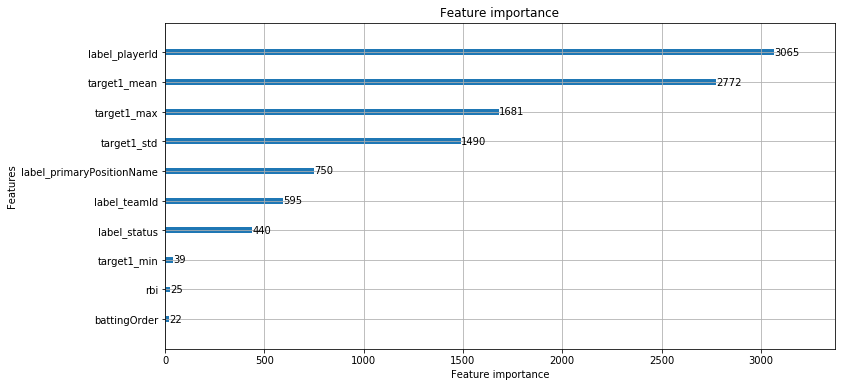

In [27]:
lgbm.plot_importance(model1, figsize=(12, 6), max_num_features=10)

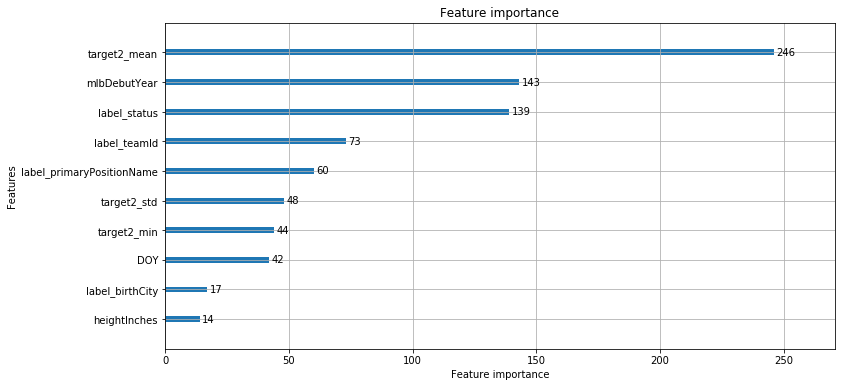

In [28]:
lgbm.plot_importance(model2, figsize=(12, 6), max_num_features=10)

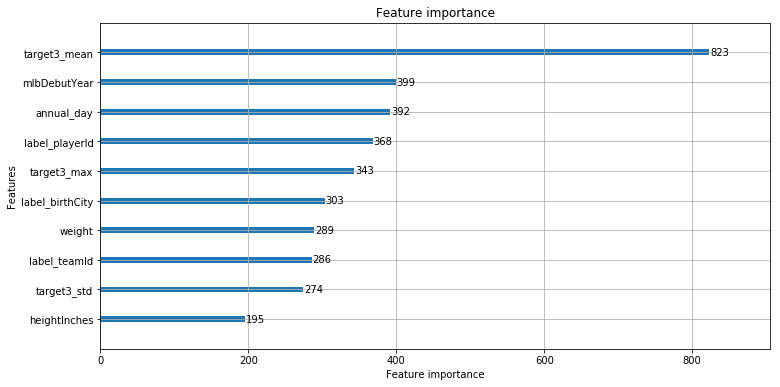

In [29]:
lgbm.plot_importance(model3, figsize=(12, 6), max_num_features=10)

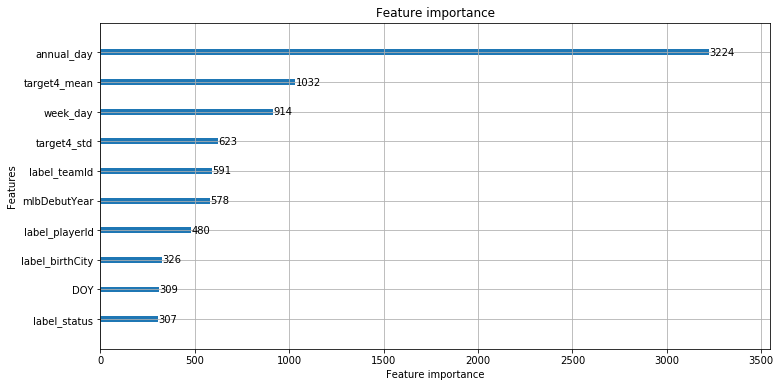

In [30]:
lgbm.plot_importance(model4, figsize=(12, 6), max_num_features=10)

## テストで取ってこれる一行はこんな感じ

In [31]:
example_sample_submission = pd.read_csv(MAIN_DATA_DIR / "example_sample_submission.csv")
example_test = pd.read_csv(MAIN_DATA_DIR / "example_test.csv")
test_df = example_test.set_index('date').iloc[:1]
sample_prediction_df = example_sample_submission[example_sample_submission['date']==test_df.index[0]].set_index('date')

In [52]:
players_cols = ['playerId', 'primaryPositionName', 'birthCity', 'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight']
rosters_cols = ['playerId', 'teamId', 'status']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

null = np.nan
true = True
false = False

# env = mlb.make_env() # initialize the environment
# iter_test = env.iter_test() # iterator which loops over each date in test set

# for (test_df, sample_prediction_df) in iter_test: # make predictions here
    
sample_prediction_df = sample_prediction_df.reset_index(drop=True)

# creat dataset
sample_prediction_df['playerId'] = sample_prediction_df['date_playerId']\
                                    .map(lambda x: int(x.split('_')[1]))
# Dealing with missing values
if test_df['rosters'].iloc[0] == test_df['rosters'].iloc[0]:
    test_rosters = pd.DataFrame(eval(test_df['rosters'].iloc[0]))
else:
    test_rosters = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
    for col in rosters.columns:
        if col == 'playerId': continue
        test_rosters[col] = np.nan

if test_df['playerBoxScores'].iloc[0] == test_df['playerBoxScores'].iloc[0]:
    test_scores = pd.DataFrame(eval(test_df['playerBoxScores'].iloc[0]))
else:
    test_scores = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
    for col in scores.columns:
        if col == 'playerId': continue
        test_scores[col] = np.nan
test_scores = test_scores.groupby('playerId').sum().reset_index()
test = sample_prediction_df[['playerId']].copy()
test = test.merge(players[players_cols], on='playerId', how='left')
test = test.merge(test_rosters[rosters_cols], on='playerId', how='left')
test = test.merge(test_scores[scores_cols], on='playerId', how='left')
test = test.merge(target_feature[targets_feature_cols], on=['playerId'], how='left')


test['label_playerId'] = test['playerId'].map(player2num)
test['label_primaryPositionName'] = test['primaryPositionName'].map(position2num)
test['label_teamId'] = test['teamId'].map(teamid2num)
test['label_status'] = test['status'].map(status2num)
test['label_birthCity'] = test['birthCity'].map(birthCityn2num)

date_ = pd.to_datetime(test_df.index[0], format="%Y%m%d")
test['annual_day'] = (date_ - pd.to_datetime(date_.year, format="%Y")) /  timedelta(days=1)
test['week_day'] = date_.weekday()
test['month'] = date_.month


test_X = test

In [54]:
# predict
pred1 = model1.predict(test_X[feature_cols1])
pred2 = model2.predict(test_X[feature_cols2])
pred3 = model3.predict(test_X[feature_cols3])
pred4 = model4.predict(test_X[feature_cols4])

# merge submission
sample_prediction_df['target1'] = np.clip(pred1, 0, 100)
sample_prediction_df['target2'] = np.clip(pred2, 0, 100)
sample_prediction_df['target3'] = np.clip(pred3, 0, 100)
sample_prediction_df['target4'] = np.clip(pred4, 0, 100)
sample_prediction_df = sample_prediction_df.fillna(0.)

del sample_prediction_df['playerId']

In [55]:
sample_prediction_df

,date_playerId,target1,target2,target3,target4
0,20210427_656669,4.523566,7.302453,2.559227e-01,2.723813
1,20210427_543475,0.147992,3.124557,2.008687e-01,1.193542
2,20210427_592866,0.006262,1.240768,1.289277e-02,1.045266
3,20210427_452678,0.028216,3.628774,4.949686e-02,1.776316
4,20210427_570257,0.008472,1.085709,1.132856e-02,0.437531
...,...,...,...,...,...
1182,20210427_593590,0.000010,0.013661,1.073450e-18,0.000000
1183,20210427_642180,0.002000,1.000161,3.896596e-03,0.397934
1184,20210427_663399,0.000242,0.336076,1.736459e-03,0.087545
1185,20210427_664199,0.000847,0.919104,5.898664e-03,0.507688
